Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import string
import regex as re
from collections import Counter
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [3]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # WordNet dataset
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

LOAD DATASET

In [2]:
df = pd.read_csv("Insurance_sentiment_analysis_dataset.csv")

In [4]:
df.head()

,category (text),category (binary),sentiment (text),sentiment (binary),feedback
0,claim,0,negative,1,I'm extremely disappointed with the lengthy an...
1,claim,0,negative,1,# Inefficient communication and lack of transp...
2,claim,0,negative,1,I recently had a terrible experience with the ...
3,claim,0,negative,1,##$ I am extremely dissatisfied with the vehic...
4,claim,0,negative,1,# Poor communication throughout the entire pro...


In [5]:
df.shape

(7585, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7585 entries, 0 to 7584
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category (text)     7585 non-null   object
 1   category (binary)   7585 non-null   int64 
 2   sentiment (text)    7585 non-null   object
 3   sentiment (binary)  7585 non-null   int64 
 4   feedback            7585 non-null   object
dtypes: int64(2), object(3)
memory usage: 296.4+ KB


HANDLING MISSING VALUES

In [7]:
df.isnull().sum()

category (text)       0
category (binary)     0
sentiment (text)      0
sentiment (binary)    0
feedback              0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(110)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

np.int64(0)

SUMMARY STATISTICS

In [11]:
df.describe()

,category (binary),sentiment (binary)
count,7475.000000,7475.000000
mean,3.756522,3.013512
std,4.523108,4.175755
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,10.000000,10.000000
max,10.000000,10.000000


In [12]:
df.describe(include=['object'])

,category (text),sentiment (text),feedback
count,7475,7475,7475
unique,3,3,7475
top,policy,negative,## Outstanding customer service at Triple AAA ...
freq,2559,2536,1


Data Preprocessing

In [13]:

df.head()

,category (text),category (binary),sentiment (text),sentiment (binary),feedback
0,claim,0,negative,1,I'm extremely disappointed with the lengthy an...
1,claim,0,negative,1,# Inefficient communication and lack of transp...
2,claim,0,negative,1,I recently had a terrible experience with the ...
3,claim,0,negative,1,##$ I am extremely dissatisfied with the vehic...
4,claim,0,negative,1,# Poor communication throughout the entire pro...


In [14]:
def clean_text(text):
    text = re.sub(r'#|\$\$|##|\n',' ',text)
    text = re.sub(r'http\S+', ' ',text)
    text = re.sub(r'\d+', ' ',text)
    text = text.lower()
    text = text.translate(str.maketrans('', '',string.punctuation))
    text = re.sub(r'\s+', ' ',text).strip()
    return text

In [17]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokens = cleaned_text.split()
    tokens =[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [19]:
df['cleaned_feedback'] = df["feedback"].apply(preprocess_text)

In [20]:
df.head()

,category (text),category (binary),sentiment (text),sentiment (binary),feedback,cleaned_feedback
0,claim,0,negative,1,I'm extremely disappointed with the lengthy an...,im extremely disappointed lengthy unsatisfacto...
1,claim,0,negative,1,# Inefficient communication and lack of transp...,inefficient communication lack transparency th...
2,claim,0,negative,1,I recently had a terrible experience with the ...,recently terrible experience vehicle insurance...
3,claim,0,negative,1,##$ I am extremely dissatisfied with the vehic...,extremely dissatisfied vehicle insurance claim...
4,claim,0,negative,1,# Poor communication throughout the entire pro...,poor communication throughout entire process u...


Exploratory Data Analysis

In [21]:
#check frequency words
all_words = [word for texts in df['cleaned_feedback'] for word in texts.split()]
word_frequency = Counter(all_words)
print(word_frequency.most_common(20))

[('insurance', 10555), ('policy', 7885), ('company', 6140), ('customer', 5954), ('vehicle', 5923), ('service', 5899), ('claim', 5812), ('process', 4650), ('experience', 3515), ('term', 3476), ('im', 2722), ('communication', 2302), ('coverage', 2283), ('would', 2161), ('recommend', 2133), ('team', 2086), ('clear', 2021), ('issue', 1939), ('lack', 1809), ('anyone', 1597)]


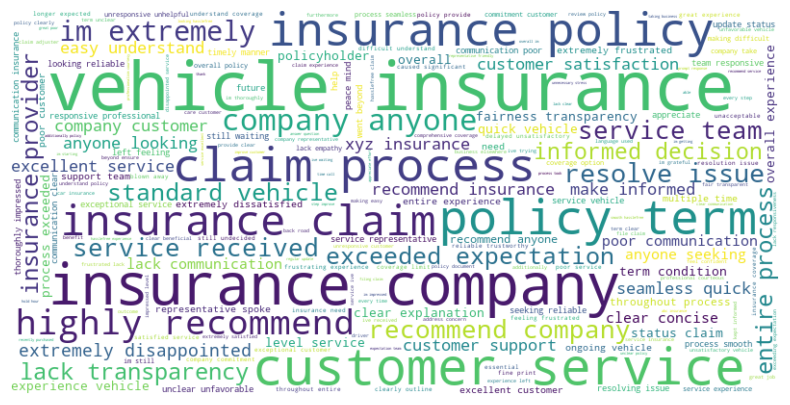

In [22]:
#Visualize Word Cloud
wordcloud = WordCloud(width=800, height=400,background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: xlabel='sentiment (text)'>

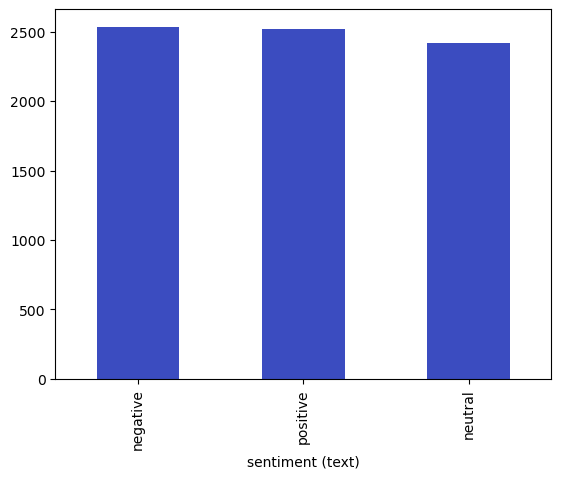

In [23]:
#Sentiment Analysis
df['sentiment (text)'].value_counts().plot(kind='bar',colormap='coolwarm')

In [24]:
# Drop the current confusing column
df = df.drop(columns=['sentiment (binary)'])

# Create a new, clean binary sentiment column from 'sentiment (text)'
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment (binary)'] = df['sentiment (text)'].map(sentiment_map)

Text(0.5, 1.0, 'Seniments Distribution')

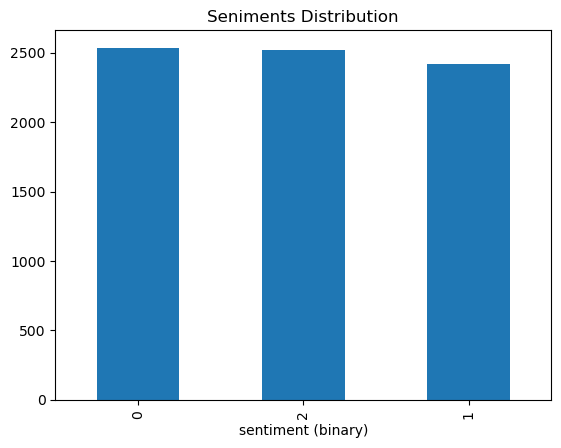

In [25]:
df['sentiment (binary)'].value_counts().plot(kind='bar').set_title("Seniments Distribution")

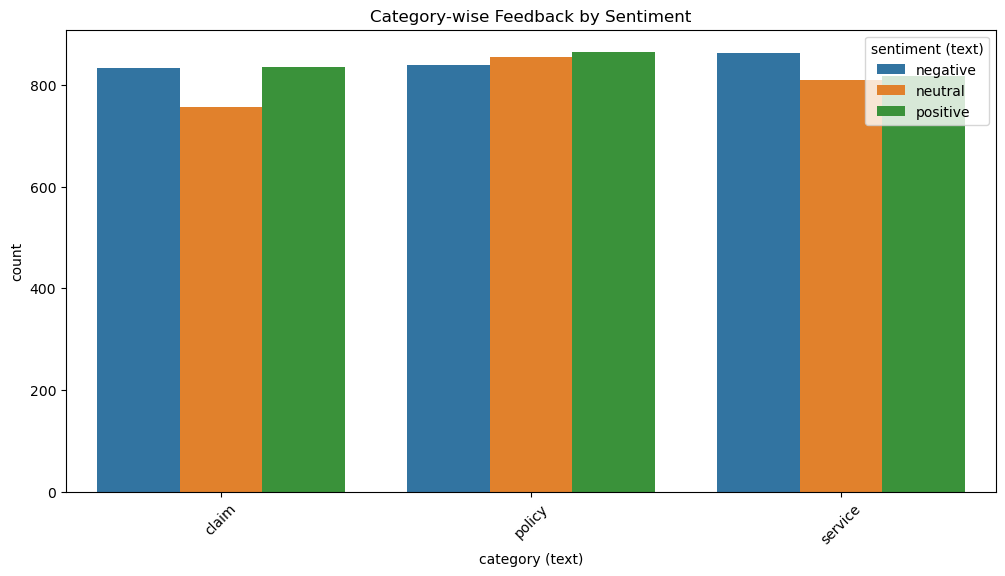

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="category (text)", hue="sentiment (text)")
plt.xticks(rotation=45)
plt.title("Category-wise Feedback by Sentiment")
plt.show()

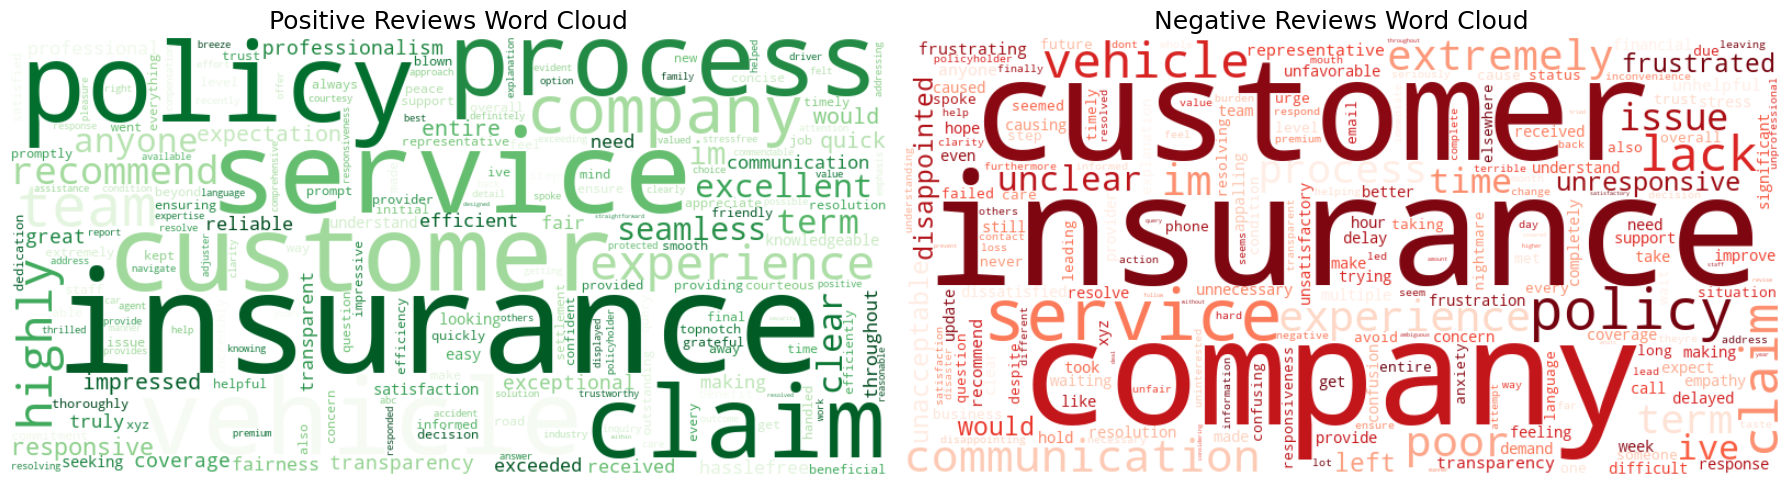

In [27]:
#Most Common Positive and Negative Reviews
from collections import Counter

# Filter
positive_texts = df[df['sentiment (text)'] == 'positive']['cleaned_feedback']
negative_texts = df[df['sentiment (text)'] == 'negative']['cleaned_feedback']

# Flatten and count words
positive_words = [word for text in positive_texts for word in text.split()]
negative_words = [word for text in negative_texts for word in text.split()]

positive_freq = Counter(positive_words)
negative_freq = Counter(negative_words)

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(positive_freq)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_freq)

# Plot them side by side
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud', fontsize=18)

plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_14660\2692539057.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_review_length.index, y=average_review_length.values, palette="coolwarm")


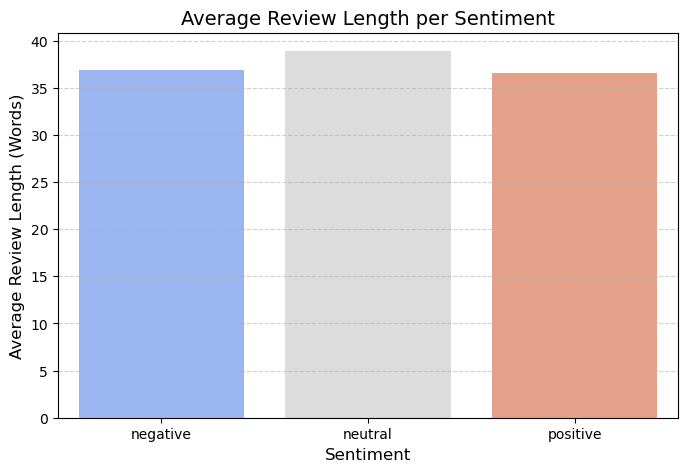

In [28]:
#Average Review length per sentiment
def length(text):
    return len(text.split())
df["Review_length"] = df["cleaned_feedback"].apply(length)
average_review_length = df.groupby("sentiment (text)")["Review_length"].mean()


plt.figure(figsize=(8,5))
sns.barplot(x=average_review_length.index, y=average_review_length.values, palette="coolwarm")

# Titles and labels
plt.title("Average Review Length per Sentiment", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Average Review Length (Words)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

Feature Selection

In [29]:
X = df['cleaned_feedback']
y = df['sentiment (binary)']

In [30]:
df['sentiment (binary)'].value_counts()

sentiment (binary)
0    2536
2    2517
1    2422
Name: count, dtype: int64

Text Vectorization (TF-IDF)

In [31]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [32]:
vectorizer = TfidfVectorizer()
x_train_vectors = vectorizer.fit_transform(X_train)
x_test_vectors = vectorizer.transform(X_test)

with open("tfidfvectorizer.pkl","wb") as file:
    pickle.dump(vectorizer,file)

print("vectorizer pickle saved sucessfully")

vectorizer pickle saved sucessfully


MODEL TRAIN AND PREDICTION

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       507
           1       0.97      0.87      0.92       484
           2       0.91      0.99      0.95       504

    accuracy                           0.95      1495
   macro avg       0.95      0.95      0.95      1495
weighted avg       0.95      0.95      0.95      1495

[[502   5   0]
 [ 15 422  47]
 [  0   7 497]]
Roc_Auc score:0.992094363714623


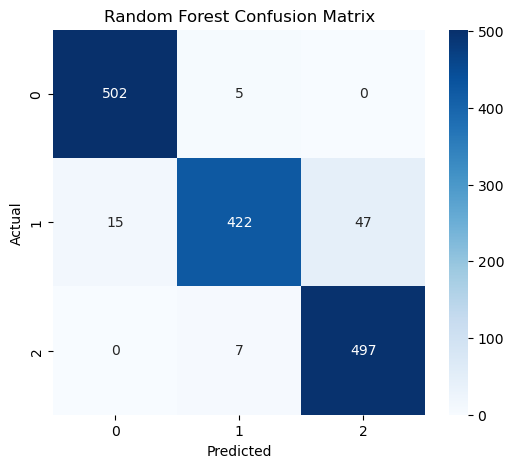

ROC AUC Score: 0.9921


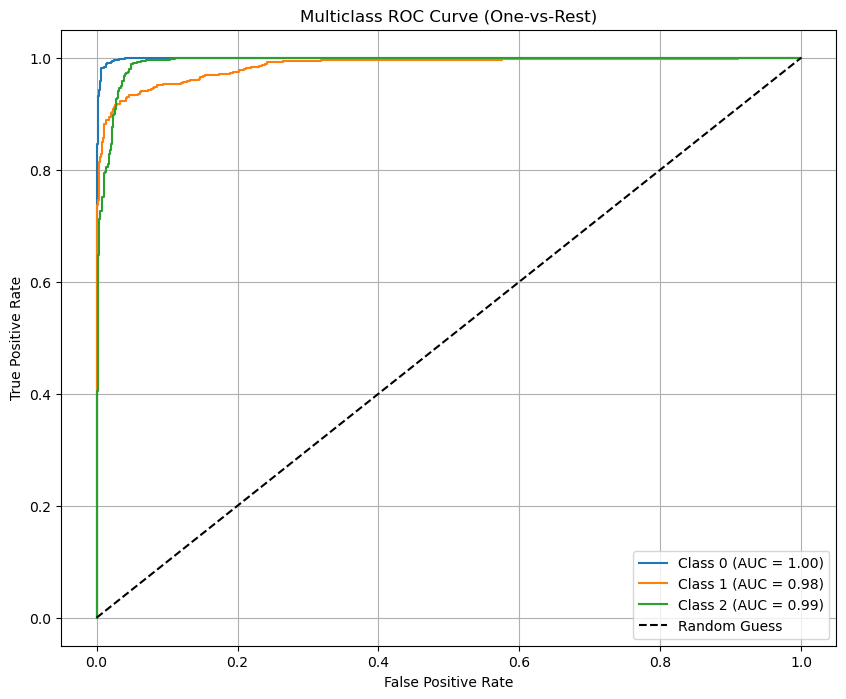

In [33]:
#NAIVE BAYES
import numpy as np
from sklearn.preprocessing import label_binarize
# Define parameter grid
param_grid = {
    'alpha': np.logspace(-2, 1, 20)  # Alpha values from 0.01 to 10
}
model_nb = MultinomialNB()

model_nb.fit(x_train_vectors, y_train)

y_pred= model_nb.predict(x_test_vectors)
y_pred_probability= model_nb.predict_proba(x_test_vectors)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(f"Roc_Auc score:{roc_auc_score(y_test,y_pred_probability,multi_class='ovr')}")

# --- 1. Confusion Matrix Heatmap ---
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC AUC Score ---
# For multiclass, need to binarize labels
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

roc_auc = roc_auc_score(y_test_binarized, y_pred_probability, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- ROC Curve for each class ---
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probability[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

0.8976588628762542
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       507
           1       0.87      0.82      0.84       484
           2       0.88      0.90      0.89       504

    accuracy                           0.90      1495
   macro avg       0.90      0.90      0.90      1495
weighted avg       0.90      0.90      0.90      1495

[[490  15   2]
 [ 27 398  59]
 [  3  47 454]]
Roc_Auc Score :0.9791384314040554


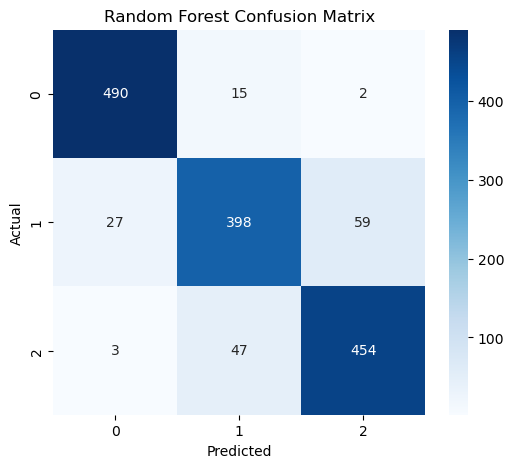

ROC AUC Score: 0.9921


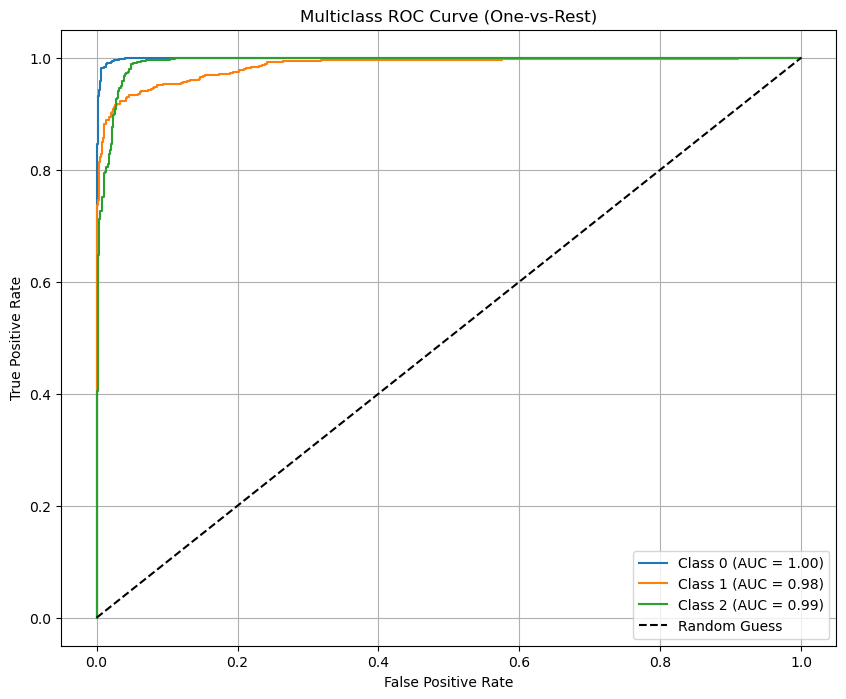

In [34]:
#Random Forest Classifier
model_rf = RandomForestClassifier(max_depth=2)
model_rf.fit(x_train_vectors,y_train)

y_pred_rf = model_rf.predict(x_test_vectors)
y_pred_proba = model_rf.predict_proba(x_test_vectors)
print(accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print(confusion_matrix(y_test,y_pred_rf))
print(f"Roc_Auc Score :{roc_auc_score(y_test,y_pred_proba,multi_class='ovr')}")

# --- 1. Confusion Matrix Heatmap ---
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC AUC Score ---
# For multiclass, need to binarize labels
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

roc_auc = roc_auc_score(y_test_binarized, y_pred_probability, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- ROC Curve for each class ---
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probability[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       507
           1       0.97      0.96      0.96       484
           2       0.97      0.98      0.98       504

    accuracy                           0.98      1495
   macro avg       0.98      0.98      0.98      1495
weighted avg       0.98      0.98      0.98      1495

[[502   5   0]
 [  7 464  13]
 [  2   9 493]]
Roc_Auc score:0.9976078473045141


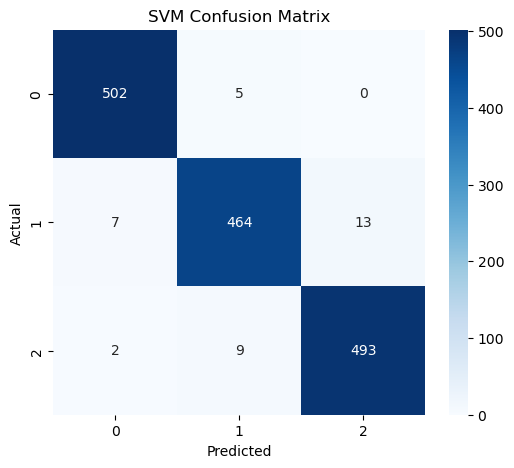

ROC AUC Score: 0.9976


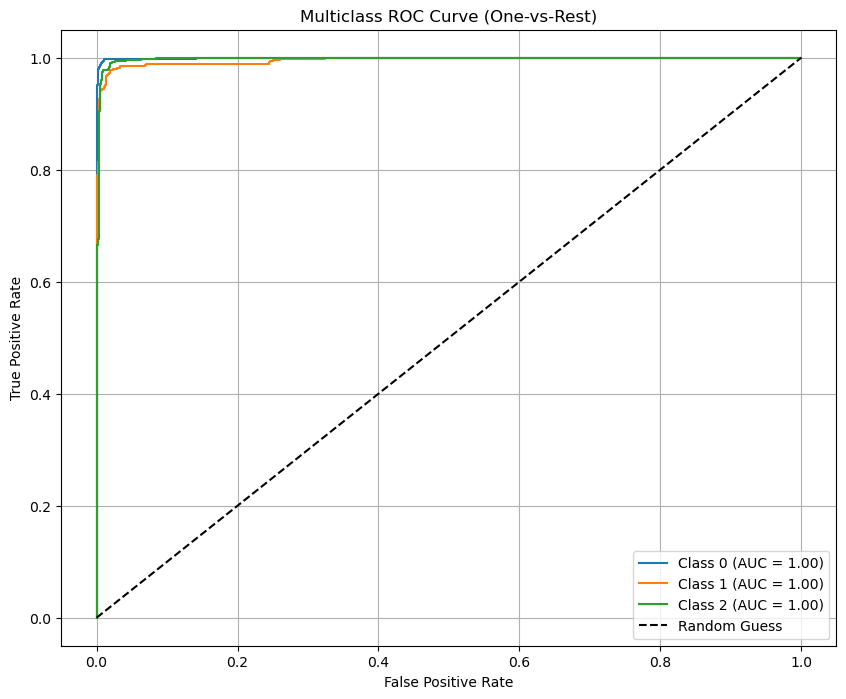

In [35]:
#SVC

model_svm = SVC(kernel='linear',C=1,probability=True)
model_svm.fit(x_train_vectors, y_train)

y_pred_svm = model_svm.predict(x_test_vectors)
y_pred_probability = model_svm.predict_proba(x_test_vectors)

print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

print(f"Roc_Auc score:{roc_auc_score(y_test,y_pred_probability,multi_class='ovr')}")


# --- 1. Confusion Matrix Heatmap ---
conf_matrix = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC AUC Score ---
# For multiclass, need to binarize labels
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

roc_auc = roc_auc_score(y_test_binarized, y_pred_probability, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- ROC Curve for each class ---
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probability[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()

Train multiple Models

D:\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Naive Bayes ---
Accuracy: 0.9505
ROC AUC: 0.9921
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       507
           1       0.97      0.87      0.92       484
           2       0.91      0.99      0.95       504

    accuracy                           0.95      1495
   macro avg       0.95      0.95      0.95      1495
weighted avg       0.95      0.95      0.95      1495

--- Logistic Regression ---
Accuracy: 0.9799
ROC AUC: 0.9976
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       507
           1       0.98      0.96      0.97       484
           2       0.98      0.98      0.98       504

    accuracy                           0.98      1495
   macro avg       0.98      0.98      0.98      1495
weighted avg       0.98      0.98      0.98      1495

--- Random Forest ---
Accuracy: 0.9645
ROC AUC: 0.9975
              precision    recall  f1-score   support

           0  

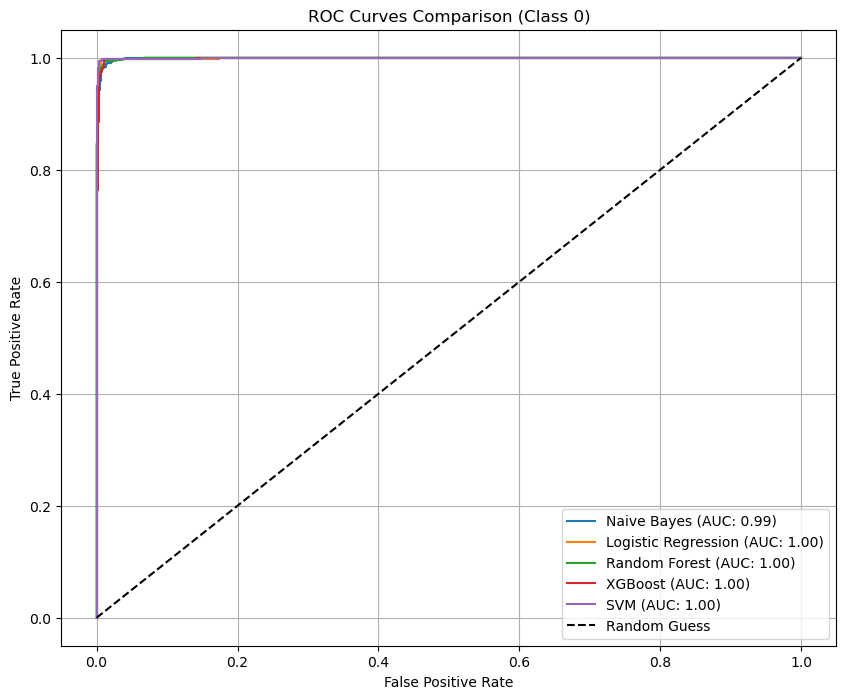

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'SVM': SVC(probability=True)
}

fitted_models = {}
for name, model in models.items():
    model.fit(x_train_vectors, y_train)
    fitted_models[name] = model

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

for name, model in fitted_models.items():
    y_pred = model.predict(x_test_vectors)
    y_proba = model.predict_proba(x_test_vectors)

    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test_binarized, y_proba, multi_class='ovr'):.4f}")
    print(classification_report(y_test, y_pred))
    print("="*50)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for name, model in fitted_models.items():
    y_proba = model.predict_proba(x_test_vectors)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(np.unique(y_test))):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Average macro AUC
    avg_auc = np.mean(list(roc_auc.values()))
    plt.plot(fpr[0], tpr[0], label=f'{name} (AUC: {avg_auc:.2f})')  # Just plotting class 0 for simplicity

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Class 0)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

saving the file

In [37]:
with open("model_sentimental_analysis.pkl","wb") as file:
    pickle.dump(model_nb,file)